In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm

In [49]:
dataset_1 = pd.read_csv("dataset_1.csv")
dataset_2 = pd.read_csv("dataset_2.csv")
dataset_3 = pd.read_csv("dataset_3.csv")
dataset_4 = pd.read_csv("dataset_4.csv")
dataset_5 = pd.read_csv("dataset_5.csv")
dataset_6 = pd.read_csv("dataset_6.csv")
datasets = [dataset_1, dataset_2, dataset_3, dataset_4, dataset_5, dataset_6]

## Exploratory Data Analysis

### Scatterplot

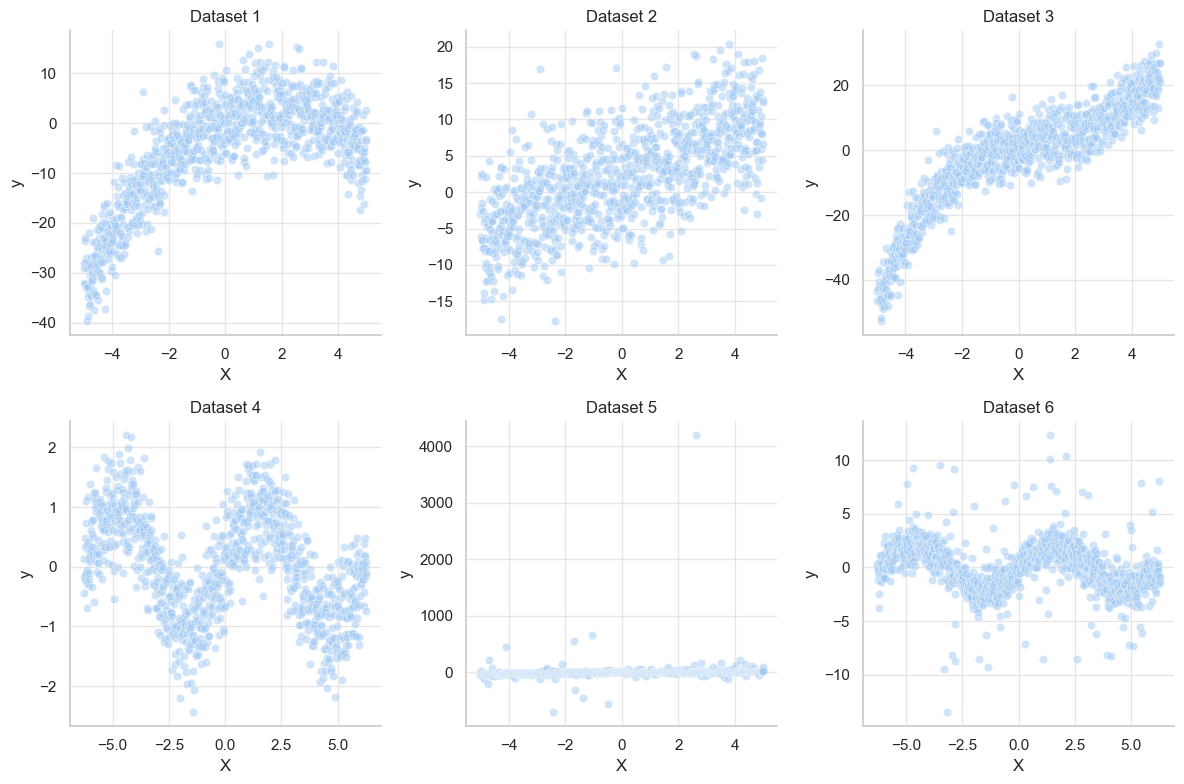

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

axes = axes.flatten()

# Aplicar el estilo aesthetic con colores pastel y cuadrícula más clara
sns.set(style="whitegrid", palette="pastel", rc={"grid.color": ".9"})

for i, (ax, data) in enumerate(zip(axes, datasets)):
    sns.scatterplot(x="X", y="y", data=data, ax=ax, alpha=0.5)
    ax.set_xlabel("X")
    ax.set_ylabel("y")
    ax.set_title(f"Dataset {i + 1}")

# Remove the top and right spines from plot(s)
sns.despine()

plt.tight_layout()
plt.show()

## 10-Fold Cross Validation

In [67]:
def train_valid_mse_per_degree(dataset: pd.DataFrame, degree: int) -> dict:
    mse_dict_per_degree = {"mse_train": [], "mse_valid": [], "model": []}

    # Split the dataset into 10 folds
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    models_list = []
    for train_index, val_index in kf.split(dataset):
        train_set = dataset.iloc[train_index]
        val_set = dataset.iloc[val_index]

        X_train = train_set[["X"]]  # `PolynomialFeatures` needs a 2D array
        y_train = train_set["y"]

        X_val = val_set[["X"]]  # `PolynomialFeatures` needs a 2D array
        y_val = val_set["y"]

        # Transform features into polynomical
        # sklearn `PolynomialFeatures`` will add a column of ones to the dataset (intercept)
        # Therefore, it's not needed to add constant with `sm.add_constant()`
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)

        # Train on the training set
        model = sm.OLS(y_train, X_train_poly).fit()
        models_list.append(model)

        # Predict on the train set
        y_train_pred = model.predict(X_train_poly)

        # Predict on the validation set
        y_val_pred = model.predict(X_val_poly)

        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_valid = mean_squared_error(y_val, y_val_pred)
        mse_dict_per_degree["mse_train"].append(mse_train)
        mse_dict_per_degree["mse_valid"].append(mse_valid)
    
    # Get the model with lowest validation error
    best_model_idx = np.argmin(mse_dict_per_degree["mse_valid"])
    best_model = models_list[best_model_idx]
    mse_dict_per_degree["model"] = best_model
    
    return mse_dict_per_degree

In [68]:
def train_valid_mse(degrees: list[int], datasets: list[pd.DataFrame]):
    mse_per_dataset_dict = {
        f"dataset_{i + 1}": {
            "mse_train": [], 
            "mse_valid": [],
            "model": []
            }
        for i in range(len(datasets))
    }
    for i, dataset in tqdm(enumerate(datasets), desc="Datasets", total=len(datasets)):
        mean_mse_train_list = []
        mean_mse_valid_list = []

        for d in degrees:
            mse_dict = train_valid_mse_per_degree(dataset, d)
            mse_per_dataset_dict[f"dataset_{i + 1}"]["model"].append(mse_dict["model"])
            
            mean_mse_train_list.append(np.mean(mse_dict["mse_train"]))
            mean_mse_valid_list.append(np.mean(mse_dict["mse_valid"]))

            mse_per_dataset_dict[f"dataset_{i + 1}"]["mse_train"] = mean_mse_train_list
            mse_per_dataset_dict[f"dataset_{i + 1}"]["mse_valid"] = mean_mse_valid_list

    return mse_per_dataset_dict

In [69]:
mse_per_dataset_dict = train_valid_mse(degrees=range(1, 16), datasets=datasets)

Datasets: 100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


## Plotting

### Training and Validation Error Evolution by Complexity

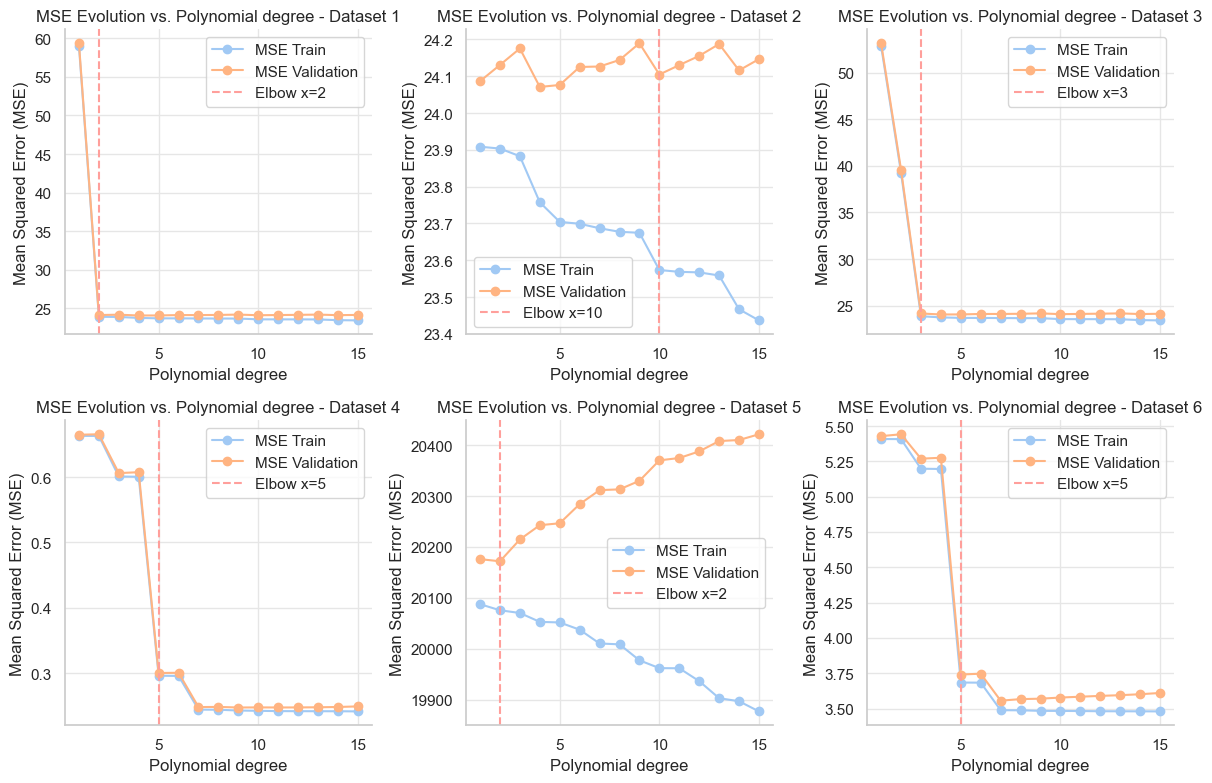

In [108]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

axes = axes.flatten()

for i, (ax, dataset) in enumerate(zip(axes, mse_per_dataset_dict)):
    ax.plot(
        range(1, 16),  # Degrees
        mse_per_dataset_dict[dataset]["mse_train"],
        marker="o",
        label="MSE Train",
    )
    ax.plot(
        range(1, 16),  # Degrees
        mse_per_dataset_dict[dataset]["mse_valid"],
        marker="o",
        label="MSE Validation",
    )
    validation_mse = mse_per_dataset_dict[dataset]["mse_valid"]
    degree_min_mse = np.argmin(validation_mse) + 1

    # Method of the second derivative to find the elbow point
    # The biggest slope change in the second derivative is the elbow point
    second_derivative = np.diff(validation_mse, n=2)
    elbow_point = np.argmax(second_derivative) + 2  # +2 porque np.diff reduce el tamaño del array original en 2

    ax.axvline(x=elbow_point, color='r', linestyle='--', label=f'Elbow x={elbow_point}')
    ax.set_xlabel("Polynomial degree")
    ax.set_ylabel("Mean Squared Error (MSE)")
    ax.set_title(f"MSE Evolution vs. Polynomial degree - Dataset {i + 1}")
    ax.legend()

# Remove the top and right spines from plot(s)
sns.despine()

plt.tight_layout()
plt.show()

A partir del punto de codo se puede determinar el grado polinómico óptimo que evita que, al aumentar la complejidad del modelo más allá de ese punto, la reducción del error deje de ser significativa y el error de validación comience a aumentar. Esto indica que el modelo está sobre-aprendiendo; reduciendo su capacidad de generalización para el conjunto de validación.

En otras palabras, el sesgo se reduce mientras que la varianza comienza a aumentar.

En la imagen superior, se puede ver el grado óptimo de la regresión polinómica marcado con una recta roja discontinua.

Los grados óptimos serían:
- **dataset_1**: `2`
- **dataset_2**: `4` (En este caso, dada la forma que presenta el error de validación, el punto codo no es efectivo para determinar el grado. En este caso el grado a escoger debe ser el que menor error de validación presente)
- **dataset_3**: `3`
- **dataset_4**: `5`
- **dataset_5**: `2`
- **dataset_6**: `5`

#### **Sesgo vs. Varianza**

El **sesgo** consiste en el error que se introduce cuando el modelo es demasiado simple y no tiene la capacidad para representar completamente todas las relaciones entre los datos. Esto se observa cuando ambos errores de entrenamiento y de validación son altos.

La **varianza** consiste en el error debido a un modelo sensible a las fluctuaciones de los datos. En estos casos, dado que el modelo se entrena con el conjunto de entrenamiento, este captura muy bien las variaciones en las relaciones de este mismo conjunto, sin embargo, no es igual de bueno con el conjunto de validación. Esto se observa cuando el error del conjunto de entrenamiento es muy bajo frente al error de validación

### Representation of the estimated function

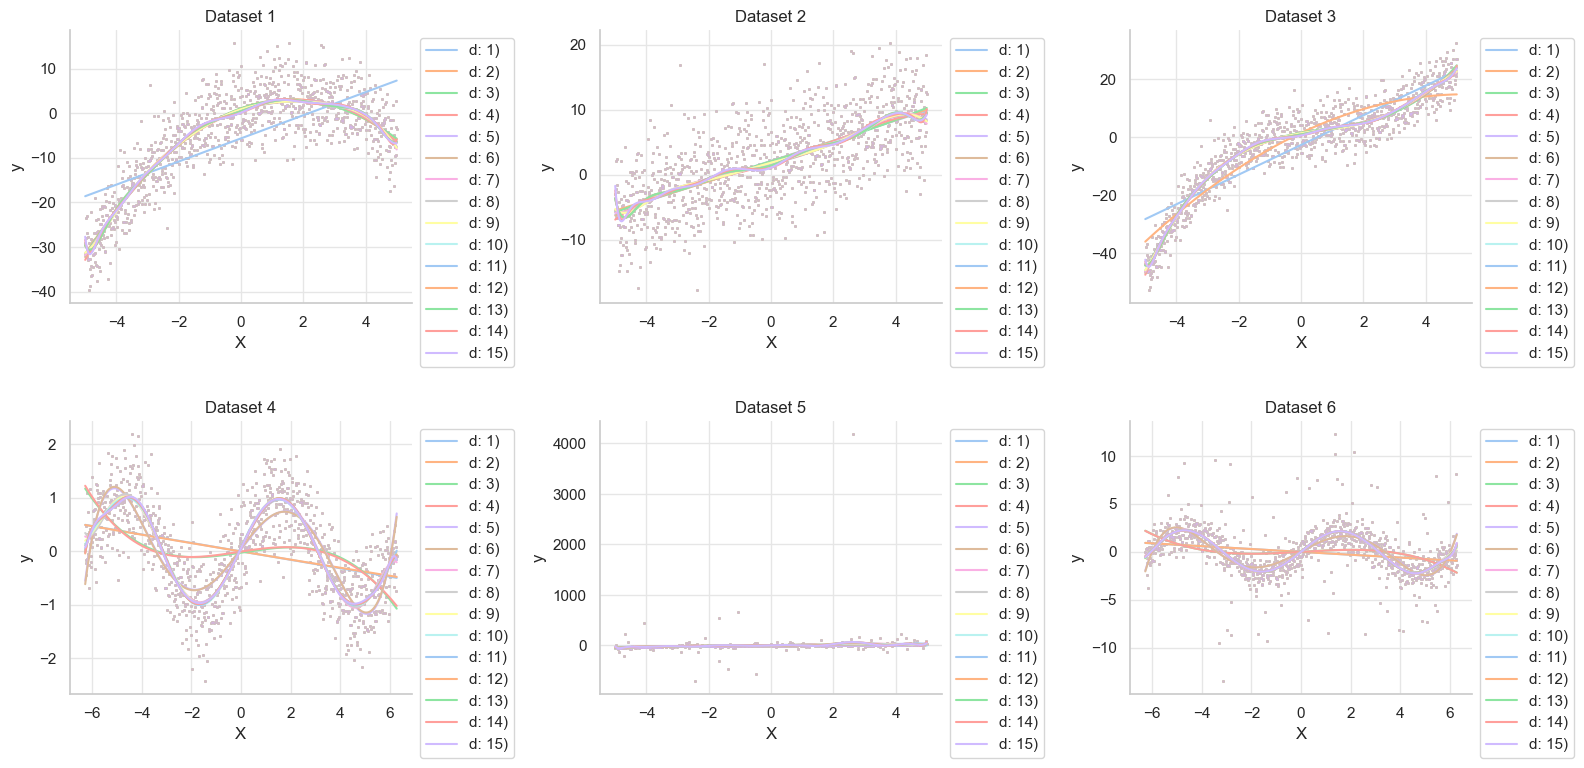

In [101]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

axes = axes.flatten()

for i, (ax, dataset) in enumerate(zip(axes, mse_per_dataset_dict)):
    dataset_x = datasets[i][["X"]]
    for d, model in enumerate(mse_per_dataset_dict[dataset]["model"]):
        y_pred = model.predict(PolynomialFeatures(degree=d+1).fit_transform(dataset_x))
        ax.plot(dataset_x, y_pred, label=f"d: {d+1})")
        ax.scatter(dataset_x, datasets[i]["y"], alpha=0.3, s=1)
    ax.set_xlabel("X")
    ax.set_ylabel("y")
    ax.set_title(f"Dataset {i + 1}")
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Remove the top and right spines from plot(s)
sns.despine()

plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.tight_layout()
plt.show()

En esta gráfica se puede observar, para cada dataset, la forma de las funciones estimadas porla regresión polinómica para cada grado. Por ejemplo en el `dataset_1` se puede observar como la función de grado 1 es una recta, la de grado 2 es una curva, y a medida que aumentan los grados, la curva intenta adaptarse más al conjunto de datos. esto también se observa claramente en los `dataset_4` y `dataset_6`